# Remove features with very low variance

If the features have a very low variance (i.e. very close to 0), they are close to being constant and thus, do not add any value to any model at all. It would just be nice to get rid of them and hence lower the complexity.

```
from sklearn.feature_selection import VarianceThreshold
data = ...
var_thresh = VarianceThreshold(threshold=0.1)
transformed_data = var_thresh.fit_transform(data)
# transformed data will have all columns with variance less
# than 0.1 removed
```



# Remove features which have a high correlation

For calculating the correlation between different numerical features, you can use the **Pearson correlation**.


In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing

# fetch a regression dataset
data = fetch_california_housing()
X, col_names, y = data.data, data['feature_names'], data.target

# convert to pandas dataframe
df = pd.DataFrame(X, columns=col_names)

# introduce a highly correlated column
df.loc[:, "MedInc_Sqrt"] = df.MedInc.apply(np.sqrt)

# get correlation matrix (pearson)
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc_Sqrt
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.984329
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,-0.132797
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.326688
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.066910
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,0.018415
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,0.015266
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.084303
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.015569
MedInc_Sqrt,0.984329,-0.132797,0.326688,-0.066910,0.018415,0.015266,-0.084303,-0.015569,1.000000


We see that the feature *MedInc_Sqrt* has a very high correlation with *MedInc*. We can thus remove one of them. 

# Univariate ways of feature selection


**Univariate feature selection** is nothing but a scoring of each feature against a given target.
**Mutual information, ANOVA F-test** and **chi2** are some of the most popular methods for univariate feature selection. There are two ways of using these in scikitlearn.
- `SelectKBest`: It keeps the top-k scoring features
- `SelectPercentile`: It keeps the top features which are in a percentage
specified by the user  

It must be noted that you can use **chi2** only for data which is non negative in nature. This is a particularly useful feature selection technique in natural language processing when we have a bag of words or tf-idf based features. It’s best to create a wrapper for univariate feature selection that you can use for almost any new problem.

In [3]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile

class UnivariateFeatureSelection:
  def __init__(self, n_features, problem_type, scoring):
      '''
      Custom univariate feature selection wrapper on
      different univariate feature selection models from
      scikit-learn.
      :param n_features: SelectPercentile if float else SelectKBest
      :param problem_type: classification or regression
      :param scoring: scoring function, string
      '''
      # for a given problem type, there are only
      # a few valid scoring methods
      # you can extend this with your own custom
      # methods if you wish
      if problem_type == 'classification':
        valid_scoring = {
            'f_classif': f_classif,
            'mutual_info_classif': mutual_info_classif,
            'chi2': chi2,
        }
      
      else:
        valid_scoring = {
            'f_regression': f_regression,
            'mutual_info_regression': mutual_info_regression,
        }
      
      # raise exception if we do not have a valid scoring method
      if scoring not in valid_scoring:
        raise Exception('Invalid Scoring function')
      
      # if n_features is int, we use selectkbest
      # if n_features is float, we use selectpercentile
      # please note that it is int in both cases in sklearn
      if isinstance(n_features, int):
        self.selection = SelectKBest(valid_scoring[scoring], k=n_features)
      
      elif isinstance(n_features, float):
        self.selection = SelectPercentile(valid_scoring[scoring],
                                percentile= int(n_features * 100),
                    )
      else:
        raise Exception('Invalid type of feature')
    
  # same fit function
  def fit(self, X, y):
    return self.selection.fit(X, y)
    
  # same transform
  def transform(self, X):
    return self.selection.transform(X)
  
  # same fit_transform
  def fit_transform(self, X, y):
    return self.selection.fit_transform(X, y)


Using this class is pretty simple


```
ufs = UnivariateFeatureSelction(
        n_features=0.1,
        problem_type="regression",
        scoring="f_regression"
)

ufs.fit(X, y)

X_transformed = ufs.transform(X)
```



Univariate feature selection may not always perform well. Most of the time, people prefer doing feature selection using a machine learning model. Let’s see how that is done.  
The simplest form of feature selection that uses a model for selection is known as **greedy feature selection**. In greedy feature selection, the **first step** is to choose a model. **The second step** is to select a loss/scoring function. And the **third** and final step is to iteratively evaluate each feature and add it to the list of “good” features if it improves loss/score.  

Let’s see how it works by looking at how its implemented

In [4]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import metrics
from sklearn.datasets import make_classification


class GreedyFeatureSelection:
  '''
  A simple and custom class for greedy feature selection.
  You will need to modify it quite a bit to make it suitable
  for your dataset.
  '''
  def evaluate_score(self, X, y):
   '''
   This function evaluates model on data and returns
   Area Under ROC Curve (AUC)
   NOTE: We fit the data and calculate AUC on same data.
   WE ARE OVERFITTING HERE.
   But this is also a way to achieve greedy selection.
   k-fold will take k times longer.
   If you want to implement it in really correct way,
   calculate OOF AUC and return mean AUC over k folds.
   :param X: training data
   :param y: targets
   :return: overfitted area under the roc curve
   '''
   # fit the logistic regression model,
   # and calculate AUC on same data
   # again: BEWARE
   # you can choose any model that suits your data
   model = linear_model.LogisticRegression()
   model.fit(X, y)
   predictions = model.predict_proba(X)[:, 1]
   auc = metrics.roc_auc_score(y, predictions)
   
   return auc

  def _feature_selection(self, X, y):
    '''
    This function does the actual greedy selection
    :param X: data, numpy array
    :param y: targets, numpy array
    :return: (best scores, best features)
    '''

    # initialize good features list
    # and best scores to keep track of both
    good_features = []
    best_scores = []

    # calculate the number of features
    num_features = X.shape[1]

    # infinite loop
    while True:
      # initialize best feature and score of this loop
      this_feature = None
      best_score = 0

      # loop over all features
      for feature in range(num_features):
        # if feature is already in good features,
        # skip this for loop
        if feature in good_features:
          continue

        # selected features are all good features till now
        # and current feature
        selected_features = good_features + [feature]

        # remove all other features from data
        xtrain = X[:, selected_features]

        # calculate the score, in our case, AUC
        score = self.evaluate_score(xtrain, y)

        # if score is greater than the best score
        # of this loop, change best score and best feature
        if score > best_score:
          this_feature = feature
          best_score = score
      
      # if we have selected a feature, add it
      # to the good feature list and update best scores list
      if this_feature != None:
        good_features.append(this_feature)
        best_scores.append(best_score)
      
      # if we didnt improve during the last two rounds,
      # exit the while loop
      if len(best_scores) > 2:
        if best_scores[-1] < best_scores[-2]:
          break
      
    # return best scores and good features
    return best_scores[:-1], good_features[:-1]

  def __call__(self, X, y):
    '''
    Call function will call the class on a set of arguments
    '''
    # select features, return scores and selected indices
    scores, features = self._feature_selection(X, y)

    # transform data with selected features
    return X[:, features], scores

In [5]:
# generate binary classification data
X, y = make_classification(n_samples=1000, n_features=100)

# transform data by greedy feature selection
X_transformed, scores = GreedyFeatureSelection()(X, y)

In [6]:
X_transformed

array([[ 2.49465684,  0.45834549, -0.654047  , ...,  1.45420819,
        -1.31165788, -0.93561029],
       [ 1.63012884,  0.1387105 ,  0.14786767, ...,  0.17249789,
         0.60340295, -0.03461217],
       [ 0.34413772, -1.49736071,  1.13457406, ..., -0.99008602,
        -1.66534354,  0.71360958],
       ...,
       [-1.37227136, -2.3429267 , -1.61080285, ...,  0.00478079,
         0.82940437, -0.39292466],
       [-0.78435632,  1.01822594,  0.31546725, ..., -0.2391723 ,
        -0.43753159,  0.19486585],
       [-0.20977253,  0.09279691,  0.10827515, ..., -2.15896469,
        -0.33161366, -0.3331654 ]])

In [7]:
scores

[0.9645279999999999,
 0.9666760000000001,
 0.967468,
 0.9682399999999999,
 0.968796,
 0.96938,
 0.969996,
 0.9705439999999999,
 0.971008,
 0.971616,
 0.972036,
 0.97238,
 0.9727239999999999,
 0.973,
 0.973316,
 0.9736199999999999,
 0.9739199999999999,
 0.9740279999999999,
 0.9741120000000001,
 0.974352,
 0.974532,
 0.97478,
 0.9749800000000001,
 0.975104,
 0.975344,
 0.975492,
 0.975776,
 0.97596,
 0.9761839999999999,
 0.976308,
 0.976388,
 0.9766279999999999,
 0.976796,
 0.9769760000000001,
 0.977152,
 0.9773839999999999,
 0.977476,
 0.9775,
 0.977536,
 0.9776119999999999,
 0.977656,
 0.977768,
 0.977892,
 0.977996,
 0.9780279999999999,
 0.978076,
 0.9780880000000001,
 0.978092]

# Recursive Feature Elimination (RFE)

In the previous method, we started with one feature and kept adding new features, but in RFE, we start with all features and keep removing one feature in every iteration that provides the least value to a given model. But how to do we know which feature offers the least value? Well, if we use models like linear support vector machine (SVM) or logistic regression, we get a coefficient for each feature which decides the importance of the features. In case of any tree-based models, we get feature importance in place of coefficients. In each iteration, we can eliminate the least important feature and keep eliminating it until we reach the number of features needed. So, yes, we have the ability to decide how many features we want to keep.

In [8]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

# fetch a regression dataset
data = fetch_california_housing()
X, col_names, y = data.data, data['feature_names'], data.target

# initialize the model
model = LinearRegression()

# initialize RFE
rfe = RFE(estimator=model, n_features_to_select=3)

# fit RFE
rfe.fit(X, y)

# get the transformed data with
# selected columns
X_transformed = rfe.transform(X)

We saw two different greedy ways to select features from a model. But you can also
fit the model to the data and select features from the model by the feature
coefficients or the importance of features. If you use coefficients, you can select
a threshold, and if the coefficient is above that threshold, you can keep the feature
else eliminate it.

Let’s see how we can get feature importance from a model like random forest.

In [9]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()

# fit the model
model.fit(X, y)

RandomForestRegressor()

Feature importance from random forest (or any model) can be plotted as follows

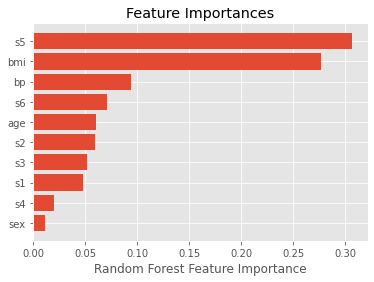

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

Well, selecting the best features from the model is nothing new. You can choose features from one model and use another model to train. For example, you can use **Logistic Regression** coefficients to select the features and then use **Random Forest** to train the model on chosen features. Scikit-learn also offers `SelectFromModel` class that helps you choose features directly from a given model. You can also
specify the threshold for coefficients or feature importance if you want and the maximum number of features you want to select.

In [12]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()

# select from the model
sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(X, y)

# see which features were selected
support = sfm.get_support()

# get feature names
print([
 x for x, y in zip(col_names, support) if y == True
])

['bmi', 's5']
